# Example notebook for CIFAR image classification training
In this example notebook, we'll guide you through the processing of training a CNN with Adam and FishLeg optimizers and getting results. 

## Step 0: Import necessary packages

In [30]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import copy
from torchsummary import summary

import time
import os
import sys
import matplotlib.pyplot as plt
import torch.optim as optim
from datetime import datetime
from utils import class_accuracy
from torch.utils.tensorboard import SummaryWriter
from data_utils import read_data_sets

torch.set_default_dtype(torch.float32)

sys.path.append("../src")

from optim.FishLeg import FishLeg, FISH_LIKELIHOODS, initialise_FishModel


## Step 1: Set up the environment for training the CNN


In [18]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

seed = 13
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step 2: Construct the function for training model

In [36]:
def train_model(model, train_loader, test_loader, opt, likelihood, class_accuracy, epochs=2, device='cuda'):
    training_loss_per_step = []
    training_acc_per_step = []
    testing_loss_per_step = []
    testing_acc_per_step = []
    time_per_step = []
    st = time.time()
    eval_time = 0

    for epoch in range(1, epochs + 1):
        with tqdm(train_loader, unit="batch") as tepoch:
            running_loss = 0
            running_acc = 0
            for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
                tepoch.set_description(f"Epoch {epoch}")

                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

                opt.zero_grad()
                output = model(batch_data)

                loss = likelihood(output, batch_labels)

                running_loss += loss.item()
                running_acc += class_accuracy(output, batch_labels).item()
                training_loss_per_step.append(loss.item())
                training_acc_per_step.append(class_accuracy(output, batch_labels).item())

                loss.backward()
                opt.step()

                et = time.time()
                time_per_step.append(et - st)
                if n % 50 == 0:
                    model.eval()

                    running_test_loss = 0
                    running_test_acc = 0

                    for m, (test_batch_data, test_batch_labels) in enumerate(test_loader, start=1):
                        test_batch_data, test_batch_labels = test_batch_data.to(device), test_batch_labels.to(device)

                        test_output = model(test_batch_data)

                        test_loss = likelihood(test_output, test_batch_labels)

                        running_test_loss += test_loss.item()
                        running_test_acc += class_accuracy(test_output, test_batch_labels).item()
                        testing_loss_per_step.append(test_loss.item())
                        testing_acc_per_step.append(class_accuracy(test_output, test_batch_labels).item())

                    running_test_loss /= m
                    running_test_acc /= m

                    tepoch.set_postfix(acc=100 * running_acc / n, test_acc=running_test_acc * 100)
                    model.train()
                    eval_time += time.time() - et
            
            epoch_time = time.time() - st - eval_time
            tepoch.set_postfix(loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time)

    return model, training_loss_per_step, training_acc_per_step, testing_loss_per_step, testing_acc_per_step, time_per_step

## Step 3: Reading in CIFAR data

In [20]:
dataset = read_data_sets("MNIST", "../data/", if_autoencoder=False, reshape=False)

Begin loading data for MNIST
Data read from ../data/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/data/MNIST_data/t10k-images-idx3-ubyte.gz
Data read from ../data/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/data/MNIST_data/t10k-labels-idx1-ubyte.gz
Succesfully loaded MNIST dataset.


In [21]:
## Dataset
train_dataset = dataset.train
test_dataset = dataset.test

print("Train size: ", train_dataset.num_examples)
print("Test size: ", test_dataset.num_examples)
print("Image shape: ", train_dataset.images.shape[1:])

Train size:  60000
Test size:  10000
Image shape:  (1, 28, 28)


In [22]:
def plot_images(dataset, n_images):
    fig, ax = plt.subplots(1, n_images, figsize=(n_images, 1))
    for i in range(n_images):
        ax[i].imshow(dataset.images[i].reshape(28, 28), cmap="gray")
        ax[i].axis("off")
        label_one_hot = train_dataset.labels[i]
        label = np.argmax(label_one_hot)
        ax[i].set_title(f"Label: {label}")
    plt.show()

### Plots of Images for Classification

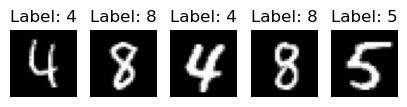

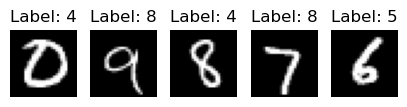

In [24]:
plot_images(train_dataset, 5)
plot_images(test_dataset, 5)

In [25]:
batch_size = 500


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

aux_loader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Step 4: Initialise the model

The following code constructs a vanilla CNN model.

In [26]:

model = nn.Sequential(
    nn.Conv2d(
        in_channels=1,
        out_channels=16,
        kernel_size=5,
        stride=1,
        padding=2,
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    # nn.Conv2d(
    #     in_channels=16,
    #     out_channels=32,
    #     kernel_size=5,
    #     stride=1,
    #     padding=2,
    # ),
    # nn.ReLU(),
    # nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(16 * 14 * 14, 10),
)

adam_model = copy.deepcopy(model)


scale_factor = 1
damping = 0.1
fishleg_model = initialise_FishModel(
    copy.deepcopy(model), module_names="__ALL__", fish_scale=scale_factor / damping
)


In [27]:
model = model.to(device)


### Adam CNN Summary

In [31]:
summary(adam_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
           Flatten-4                 [-1, 3136]               0
            Linear-5                   [-1, 10]          31,370
Total params: 31,786
Trainable params: 31,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.12
Estimated Total Size (MB): 0.36
----------------------------------------------------------------


## Step 5: Training with Adam
The work flow:
- We specify a custom implementation of softmax likelihood which defines the way to compute loss in our classification tasks.
- We then specify the hyperparameters: Learning rate, weight decay and optimizers.
- Lastly, we train the model with these hyperparameters and the data specified above.

Hyperparameters:
- **Learning rate**: Controls the step size in updating weights during training.
- **Weight decay**: Adds a penalty on large weights to reduce overfitting and improve model generalization.
- **Optimizer**: An algorithm that adjusts weights adaptively for each parameter to minimize the loss function more efficiently.

In [32]:
# This is a custom implementation of a softmax likelihood which defines the way to compute loss in classification tasks
likelihood = FISH_LIKELIHOODS["softmax"](device=device)

lr = 0.0005
# betas = (0.7, 0.9)
weight_decay = 1e-5
# eps = 1e-8

opt = optim.Adam(
    model.parameters(),
    lr=lr,
    # betas=betas,
    weight_decay=weight_decay,
    # eps=eps,
)


trained_model = train_model(model, train_loader, test_loader, opt, likelihood, class_accuracy, epochs=2, device=device)


  0%|          | 0/120 [00:00<?, ?batch/s]/Users/weibinchen/Desktop/UCL/PhD_Year_1/FishLeg/examples/data_utils.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self._images[idx]), torch.tensor(self._labels[idx])
Epoch 2: 100%|██████████| 120/120 [00:08<00:00, 14.44batch/s, acc=91.7, test_acc=93.1]


## Step 6: Training with FishLeg
The workflow:
- We specify all the hyperparameters(learning rate, weight_decay,etc).
- We initialise a model with replacement of certain layers with corresponding 'FishLeg' layers
- We specify the FishLeg optimizer
- Lastly, we train the model

Hyperparameters:
- **Learning rate**: Controls the step size in updating weights during training.
- **Weight decay**: Adds a penalty on large weights to reduce overfitting and improve model generalization.
- **Optimizer**: An algorithm that adjusts weights adaptively for each parameter to minimize the loss function more efficiently.
- **beta**: coefficient for running averages of gradient (default: 0.9)
- **aux_lr**: learning rate for the auxiliary parameters, using Adam (default: 1e-3)
- **aux_eps**: Term added to the denominator to improve numerical stability for auxiliary parameters (default: 1e-8)
- **damping**: Static damping applied to Fisher matrix, :math:`\gamma`,for stability when FIM becomes near-singular. (default: 5e-1)

In [38]:
lr = 0.02
beta = 0.9
weight_decay = 1e-5

aux_lr = 1e-4
aux_eps = 1e-8
scale_factor = 1
damping = 0.1
update_aux_every = 3

initialization = "normal"
normalization = True

scale_factor = 1
damping = 0.1
fishleg_model = initialise_FishModel(
    copy.deepcopy(model), module_names="__ALL__", fish_scale=scale_factor / damping
)


# Initialise a model with replacement of certain layers with corresponding 'FishLeg' layers
model = initialise_FishModel(
    model, module_names="__ALL__", fish_scale=scale_factor / damping
)

opt = FishLeg(
    model,
    aux_loader,
    likelihood,
    lr=lr,
    beta=beta,
    weight_decay=weight_decay,
    aux_lr=aux_lr,
    aux_betas=(0.9, 0.999),
    aux_eps=aux_eps,
    damping=damping,
    update_aux_every=update_aux_every,
    # writer=writer,
    method="antithetic",
    method_kwargs={"eps": 1e-4},
    precondition_aux=True,
)


### FishLeg CNN Summary

In [34]:
summary(fishleg_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        FishConv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
           Flatten-4                 [-1, 3136]               0
        FishLinear-5                   [-1, 10]          31,370
Total params: 31,786
Trainable params: 31,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.12
Estimated Total Size (MB): 0.36
----------------------------------------------------------------


### FishLeg Model Training

In [39]:
fishleg_trained_model, fishleg_training_loss_per_step, fishleg_training_acc_per_step, fishleg_testing_loss_per_step, fishlet_testing_acc_per_step, fishleg_time_per_step = train_model(fishleg_model, train_loader, test_loader, opt, likelihood, class_accuracy, epochs=10, device=device)

Epoch 1:   0%|          | 0/120 [00:00<?, ?batch/s]


IndexError: list index out of range

### Plots of Training Process

In [ ]:
plt.plot(adam_training_loss_per_step, label="Adam")
plt.plot(fishleg_training_loss_per_step, label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Steps")
plt.ylabel("Training Loss")

In [ ]:
plt.plot(adam_training_acc_per_step, label="Adam")
plt.plot(fishleg_training_acc_per_step, label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Steps")
plt.ylabel("Training Accuracy")

In [ ]:
plt.plot(adam_time_per_step, adam_training_loss_per_step, label="Adam")
plt.plot(fishleg_time_per_step, fishleg_training_loss_per_step, label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("Training Loss")

In [ ]:
plt.plot(adam_time_per_step, adam_training_acc_per_step, label="Adam")
plt.plot(fishleg_time_per_step, fishleg_training_acc_per_step, label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("Training Accuracy")